In [7]:
# !pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from copy import deepcopy

spark = (SparkSession.builder
          .master("local[*]") \
          .appName("Spark test") \
          .config("spark.ui.showConsoleProgress","false") \
          .getOrCreate()
        )

spark

In [36]:
from typing import List
def getHistogram(df, column, nbins : int = 100, hrange:List[float]=(0,100)):
    """
    Get a histogram of a column in the DataFrame.
    
    Parameters:
    - df: Spark DataFrame
    - column: Column name to create histogram for
    - bins: Number of bins for the histogram
    - range: Range of values for the histogram
    
    Returns:
    - DataFrame with histogram data
    """
    bin_width = (hrange[1] - hrange[0]) / nbins

    bins = spark.createDataFrame([(i,) for i in range(nbins + 1)], ["bin"])

    df_h = df.withColumn("bin", F.floor((F.col(column)-hrange[0]) / bin_width))
    df_h = df_h.groupBy("bin").count()
    df_h = bins.join(df_h, on="bin", how="left").fillna(0).orderBy("bin")
    df_h = df_h \
        .withColumn("bin_start", F.col("bin") * bin_width + hrange[0]) \
        .withColumn("bin_end", F.col("bin_start") + bin_width) \
        .select("bin_start", "bin_end", "count")
    df_h = df_h.orderBy("bin_start")
    return df_h
    
def jetAnalysisDf(df):
    import re
    """
    Perform jet analysis on the DataFrame.
    This function is a placeholder for actual analysis logic.
    """
    # Example: Count the number of jets
    df = df \
        .withColumn("jet_n",F.size(F.col("jet_pt"))) \
        .filter(F.col("jet_n") > 0) \
        .withColumn("zipped", F.arrays_zip(F.col("jet_pt"), F.col("jet_eta"), F.col("jet_phi"), F.col("jet_m"))) \
        .withColumn("sorted", F.expr("array_sort(zipped, (left, right) -> case when left.jet_pt > right.jet_pt then -1 when left.jet_pt < right.jet_pt then 1 else 0 end)")) \
        .withColumn("max_pt_jet_struct", F.col("sorted")[0])
    df = df \
        .select([c for c in df.columns if re.match(r'.*_num', c)] + 
                [c for c in df.columns if re.match(r'jet_.*', c)] + 
                [F.col(f"max_pt_jet_struct.jet_{v}").alias(f"leadjet_{v}") for v in ['pt', 'eta','phi','m']])
    
    return df

def jetAnalysis(df, histograms):
    
    # df.limit(20).show(truncate=False)  # Display the first 10 rows for inspection
    for key, value in histograms.items():
        value['data'] = getHistogram(df, key, nbins=value['nbins'], hrange=value['hrange']).toPandas().to_numpy()
    
    return histograms

In [40]:
# Read the Parquet file
df_binnedshower = spark.read.parquet('/afs/cern.ch/user/v/valentem/eoswork/ATLAS/FCS/condor/outputs/PARQUET/FCS_BinnedShower/20250806/file.parquet')
df_standard = spark.read.parquet('/afs/cern.ch/user/v/valentem/eoswork/ATLAS/FCS/condor/outputs/PARQUET/FCS_Standard/20250806/file.parquet')

hist_dict = {
    'leadjet_pt': {
        'nbins': 50,
        'hrange': (0, 4_000),
        'data': None  # Placeholder for histogram data
    },
    'leadjet_eta': {
        'nbins': 100,
        'hrange': (-5.0, 5.0),
        'data': None  # Placeholder for histogram data
    },
    'leadjet_m': {
        'nbins': 50,
        'hrange': (0., 300.),
        'data': None  # Placeholder for histogram data
    },
}

df_bs = jetAnalysisDf(df_binnedshower)
df_s = jetAnalysisDf(df_standard)

hdict_binnedshower = jetAnalysis(df_bs, deepcopy(hist_dict))
hdict_standard     = jetAnalysis(df_s, deepcopy(hist_dict))


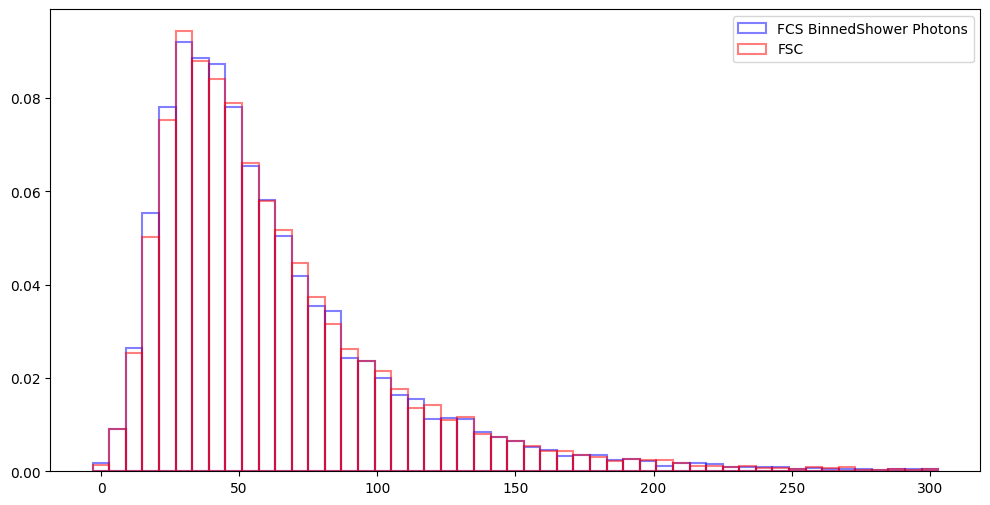

In [43]:
import matplotlib.pyplot as plt
import numpy as np

hname = 'leadjet_m'
plt.figure(figsize=(12, 6))

plt.bar(hdict_binnedshower[hname]['data'][:, 0], 
        hdict_binnedshower[hname]['data'][:, 2]/np.sum(hdict_binnedshower[hname]['data'][:, 2]),
        width=hdict_binnedshower[hname]['data'][0, 1] - hdict_binnedshower[hname]['data'][0, 0],
        label='FCS BinnedShower Photons',
        fill=False,
        edgecolor='blue',
        linewidth=1.5,
        alpha=0.5)

plt.bar(hdict_standard[hname]['data'][:, 0], 
        hdict_standard[hname]['data'][:, 2]/np.sum(hdict_standard[hname]['data'][:, 2]),
        width=hdict_standard[hname]['data'][0, 1] - hdict_standard[hname]['data'][0, 0],
        label='FSC',
        fill=False,
        edgecolor='red',
        linewidth=1.5,
        alpha=0.5)

# plt.yscale('log')
plt.legend(loc='best')